# Definimos el modelo epidemiológico

In [53]:
!pip install lmfit

In [224]:
from numpy import arange,array,dot,asarray,zeros,apply_along_axis,around,sort,shape,random,exp,empty,mean,ndarray
from scipy import integrate
from matplotlib.pyplot import plot,figure,title,legend,xlabel,ylabel,grid,axvline,savefig,hist,subplots,subplot
from scipy.stats.mstats import mquantiles
from math import sqrt,log
import pandas as pd
from datetime import datetime,timedelta
from lmfit import minimize,Parameters,Parameter,report_fit
from scipy.stats import poisson,truncnorm
import scipy
import numpy as np
from lmfit import minimize,Parameters,Parameter,report_fit
from statsmodels.graphics.tsaplots import plot_acf

In [124]:
# Modelo en términos de ODEs
def ode_SID(INP,t,alpha,beta,gamma,mu1,mu2,nu,delta):  
    Y = np.zeros((4))
    V = INP    
    Y[0] =alpha*(V[0]+V[1]) - beta * V[0] * V[2] -gamma*V[0]*V[1]-mu1*V[0]
    Y[1] = beta * V[0] * V[2]+gamma*V[0]*V[1] - mu2 * V[1] -nu* V[1]
    Y[2] =nu * V[1] - delta* V[2]
    Y[3]= beta * V[0] * V[2]+gamma*V[0]*V[1]

    return Y  

In [125]:
import scipy.integrate as spi
import numpy as np
import pylab as pl
import scipy.optimize as optimize
pl.style.use('fivethirtyeight')

In [126]:
# Especificamos parámetros y condiciones iniciales
alpha =0.02
beta = 0.015
gamma=0.001
mu1 = 0.02
mu2=0.002
nu=0.081
delta=7/365

N=12350
I0 = 1.0
D0=0.0
S0 = N-I0-D0
INPUT = (S0, I0, D0,1.)

t_start = 0.0; 
t_end = 1.5; 
t_inc = 1/365
t_range = np.arange(t_start, t_end+t_inc, t_inc)



In [127]:
#Función para calcular el número básico de reproducción 
def NumBasR(beta,mu1,nu,delta,N):
  R_0=(nu*beta*N*delta)/(mu1+nu)
  return R_0

NumBasR(beta,mu1,nu,delta,N)

2.8492269089922684

In [128]:
#Calcular la incidencia en el periodo de días indicado a partir de casos acumulados
def incidencia(Y_p,period):
  #Número de días
  n=len(Y_p)
  #Número de semanas
  m=int(n/period)
  Y_inc=zeros((m))
  Y_inc[0]=Y_p[period-1]
  for i in range(1,m):
      dif=Y_p[period*(i+1)-1]-Y_p[period*i]
      #if dif>0:
      Y_inc[i]=dif
  return Y_inc

# Usando Odeint

In [129]:
# Resolvemos usando odeint de scipy
SOL = spi.odeint(ode_SID,INPUT,t_range,args=(alpha,beta,gamma,mu1,mu2,nu,delta))

In [130]:
n_days=365*1.5
inc_quinc=incidencia(SOL[:,3],7)
#Número de quincenas completas en el periodo
n_quinc=int(n_days/7)
print(inc_quinc)
#Establecer una semilla
random.seed(seed=2022)

#Agregar ruido Poisson porque son datos discretos 
data_quinc=poisson.rvs(mu=inc_quinc,size=n_quinc)
#data_quinc=np.random.normal(size=n_quinc,scale=15)

[1.22723122e+00 2.94141191e-01 3.80616461e-01 4.92377297e-01
 6.36814312e-01 8.23473822e-01 1.06468459e+00 1.37636398e+00
 1.77905543e+00 2.29925994e+00 2.97114338e+00 3.83871832e+00
 4.95862427e+00 6.40365327e+00 8.26719573e+00 1.06688009e+01
 1.37610589e+01 1.77379923e+01 2.28450805e+01 2.93908783e+01
 3.77598793e+01 4.84257089e+01 6.19627837e+01 7.90531128e+01
 1.00482618e+02 1.27118624e+02 1.59856248e+02 1.99518679e+02
 2.46695284e+02 3.01507067e+02 3.63306106e+02 4.30349085e+02
 4.99534085e+02 5.66339774e+02 6.25121104e+02 6.69851724e+02
 6.95239517e+02 6.97927312e+02 6.77356950e+02 6.35941942e+02
 5.78469637e+02 5.10980135e+02 4.39543822e+02 3.69314766e+02
 3.04034222e+02 2.45958050e+02 1.96066246e+02 1.54396284e+02
 1.20382112e+02 9.31354093e+01 7.16489241e+01 5.49270689e+01
 4.20594736e+01 3.22546101e+01 2.48482149e+01 1.92972032e+01
 1.51664140e+01 1.21127208e+01 9.86911958e+00 8.23016912e+00
 7.03932976e+00 6.17836793e+00 5.55869445e+00 5.11442504e+00
 4.79690552e+00 4.570447

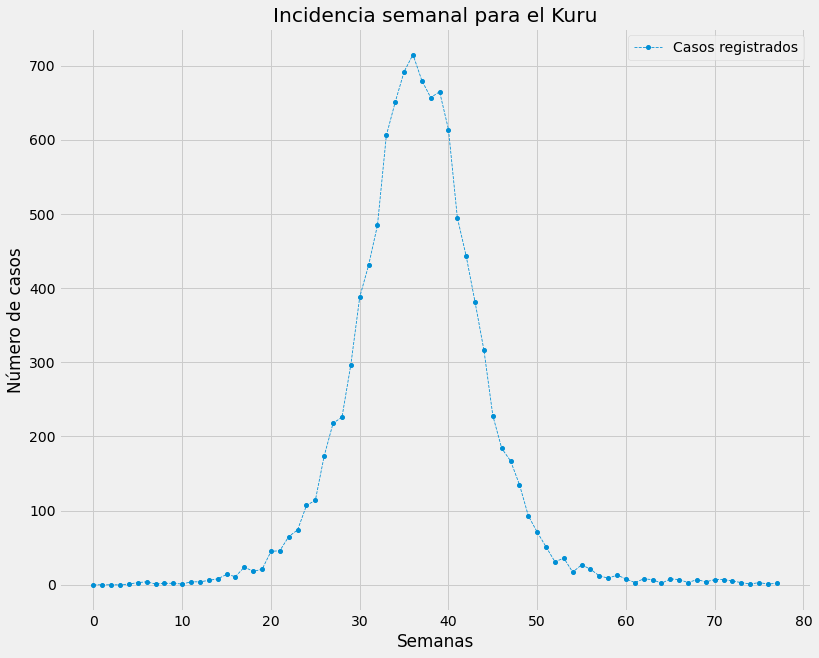

In [131]:
t_quinc=arange(0,n_quinc,1)
pl.figure(figsize=(12,10))
pl.plot(t_quinc,data_quinc,linestyle="--",marker="o",markersize=4,linewidth=0.8,label="Casos registrados")
pl.ylabel("Número de casos")
pl.xlabel("Semanas")
pl.legend()
pl.title("Incidencia semanal para el Kuru")
pl.show()

In [132]:
def residual_seics(params,x0_s,ts,datos,periodo):
    alpha,beta,gamma,mu1,mu2,nu,delta=params['alpha'].value,params['beta'].value,params['gamma'].value,params['mu1'].value,params['mu2'].value,params['nu'].value,params['delta'].value
    modelo=integrate.odeint(ode_SID,x0_s,ts,args=(alpha,beta,gamma,mu1,mu2,nu,delta,))
    aprox_dia=modelo[:,3]
    aprox_sem=incidencia(aprox_dia,periodo)
    return ((aprox_sem-datos)**2).ravel()

In [186]:
#Posibles rangos para los parámetros
params=Parameters()
#beta,kappa,gamma,epsilon,p=3/21,0.1,1/21,1/365,0.04
params.add('alpha',value=0.01,min=0,max=0.5)
params.add('beta',value=0.0015,min=0,max=0.5)
params.add('gamma',value=0.01,min=0,max=0.5)
params.add('mu1',value=0.01,min=0,max=0.5)
params.add('mu2',value=0.001,min=0,max=0.5)
params.add('nu',value=0.07,min=0,max=0.5)
params.add('delta',value=0.2,min=0,max=0.5)


#Ajustar el modelo y estimar los parámetros usando por Levenberg-Marquard
#Se utilizará incidencia quincenal
periodo=7
estimacion1=minimize(residual_seics,params,args=(INPUT,t_range,data_quinc,periodo),method='leastsq')
estimacion1

Las estimaciones encontradas de los parámetro son: Parameters([('alpha', <Parameter 'alpha', value=0.2508759787090548, bounds=[0:0.5]>), ('beta', <Parameter 'beta', value=0.04479509229290371, bounds=[0:0.5]>), ('gamma', <Parameter 'gamma', value=0.0004623952889668548, bounds=[0:0.5]>), ('mu1', <Parameter 'mu1', value=0.41043656687089514, bounds=[0:0.5]>), ('mu2', <Parameter 'mu2', value=0.4999999741201076, bounds=[0:0.5]>), ('nu', <Parameter 'nu', value=0.24458441484735077, bounds=[0:0.5]>), ('delta', <Parameter 'delta', value=0.49954046748434683, bounds=[0:0.5]>)])


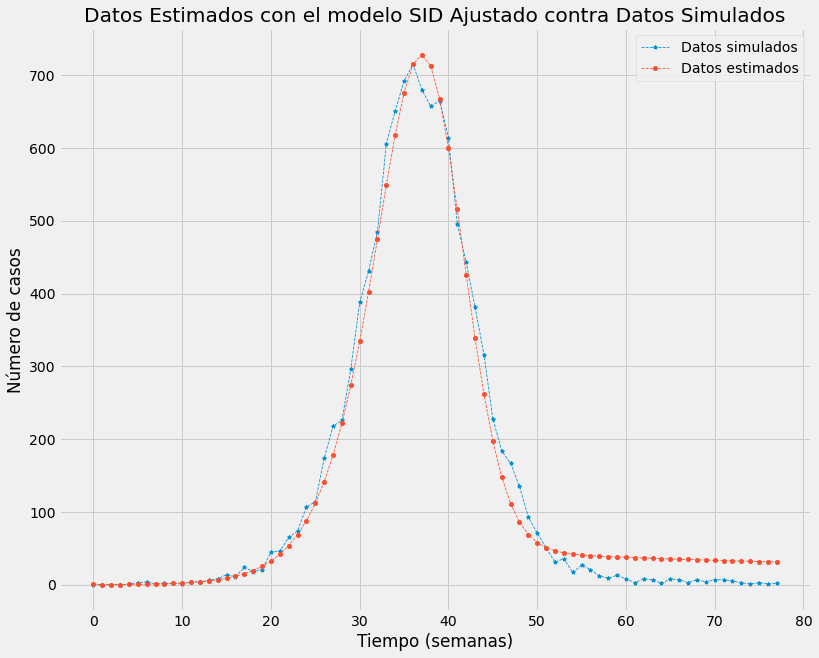

In [187]:
#Extraer parámetros estimados
param_est1=estimacion1.params
print("Las estimaciones encontradas de los parámetro son:",param_est1)

#Obtener la solución del modelo con los parámetros estimados por Levenberg-Marquard
alpha_est1,beta_est1,gamma_est1,mu1_est1,mu2_est1,nu_est1,delta_est1=param_est1['alpha'].value,param_est1['beta'].value,param_est1['gamma'].value,param_est1['mu1'].value,param_est1['mu2'].value,param_est1['nu'].value,param_est1['delta'].value   
result2=integrate.odeint(ode_SID,INPUT,t_range,args=(alpha_est1,beta_est1,gamma_est1,mu1_est1,mu2_est1,nu_est1,delta_est1,))
Y_acum2=result2[:,3]
#Incidencia quincenal del modelo ajustado
Y_quinc1=incidencia(Y_acum2,7)
#Graficar el modelo obtenido con los datos estimados contra los datos simulados
pl.figure(figsize=(12,10))
pl.plot(t_quinc,data_quinc,linestyle="--",marker="*",markersize=4,linewidth=0.8,label="Datos simulados")
pl.plot(t_quinc,Y_quinc1,linestyle="--",marker="o",markersize=4,linewidth=0.8,label="Datos estimados")
pl.ylabel("Número de casos")
pl.xlabel("Tiempo (semanas)")
pl.legend()
pl.title("Datos Estimados con el modelo SID Ajustado contra Datos Simulados")
pl.show()


In [188]:
alpha_est1,beta_est1,gamma_est1,mu1_est1,mu2_est1,nu_est1,delta_est1

(0.2508759787090548,
 0.04479509229290371,
 0.0004623952889668548,
 0.41043656687089514,
 0.4999999741201076,
 0.24458441484735077,
 0.49954046748434683)

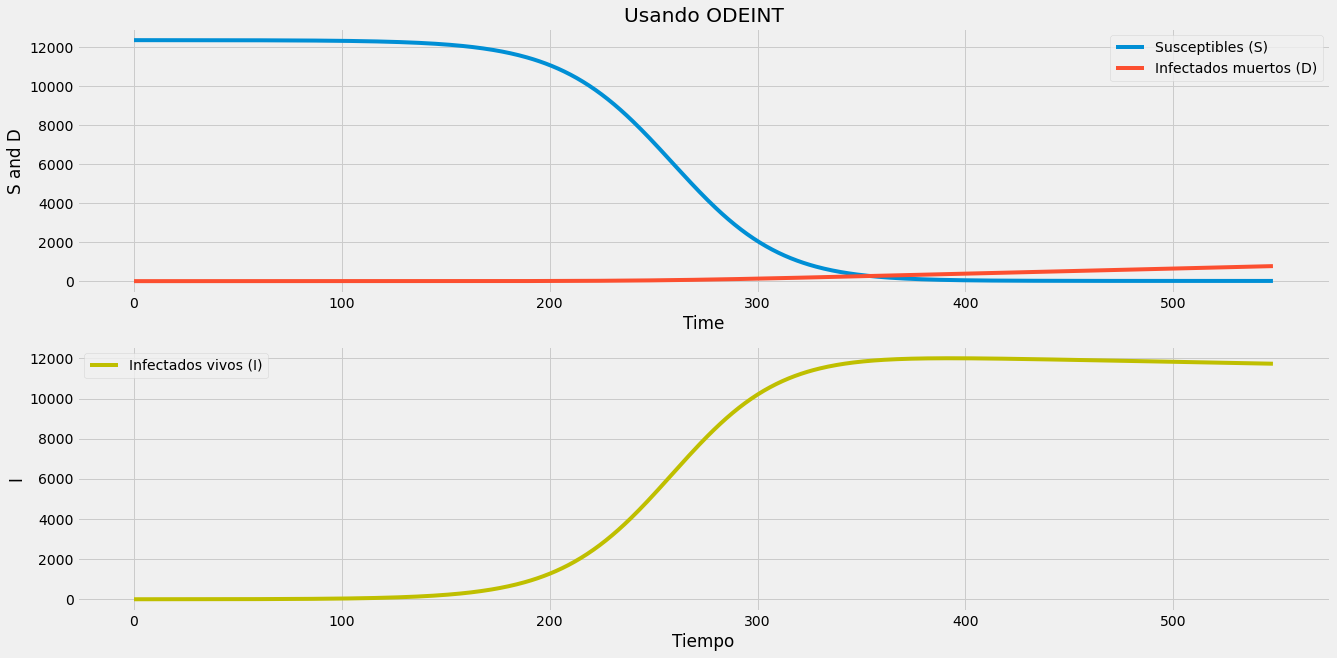

In [189]:
pl.figure(figsize=(20, 10))
pl.subplot(211)
pl.plot(SOL[:,0],  label='Susceptibles (S)')
pl.plot(SOL[:,2],  label='Infectados muertos (D)')
pl.legend(loc=0)
pl.title('Usando ODEINT')
pl.xlabel('Time')
pl.ylabel('S and D')
pl.subplot(212)
pl.plot(SOL[:,1], '-y' ,label='Infectados vivos (I)')
pl.legend(loc=0)
pl.xlabel('Tiempo')
pl.ylabel('I')
pl.show()

Graficamos en una sola gráfica

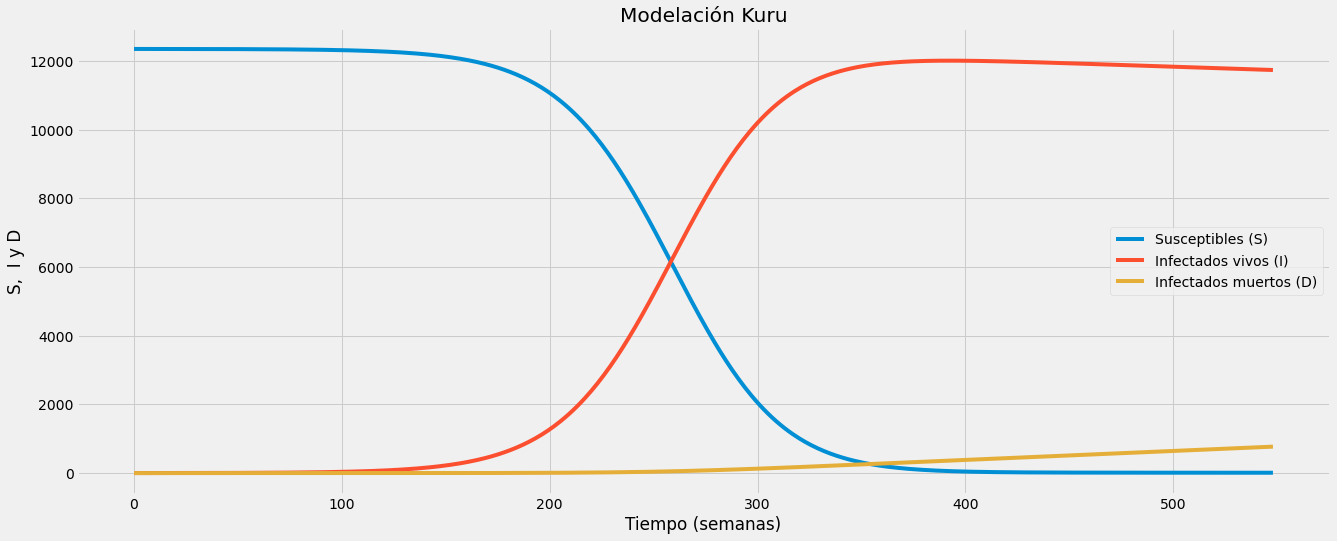

In [190]:
pl.figure(figsize=(20, 8))
pl.plot(SOL[:,0],  label='Susceptibles (S)') #S
pl.plot(SOL[:,1],  label='Infectados vivos (I)')# I
pl.plot(SOL[:,2],  label='Infectados muertos (D)') # D
pl.title('Modelación Kuru')
pl.xlabel('Tiempo (semanas)')
pl.ylabel('S,  I y D')
pl.legend(loc=0)
pl.show()


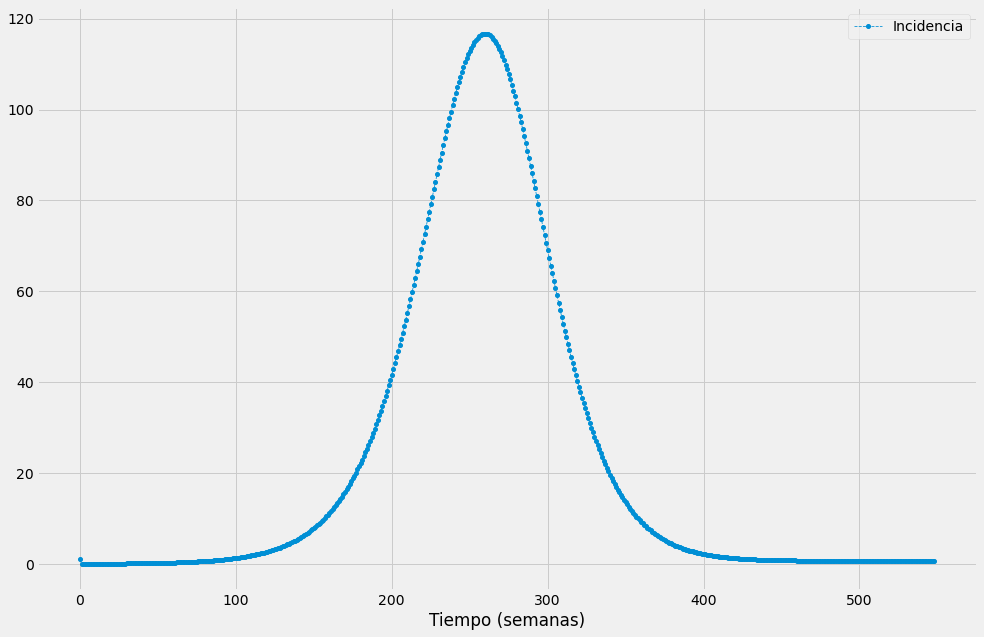

In [191]:
pl.figure(figsize=(15, 10))
inc=np.concatenate((np.array([I0]),np.diff(SOL[:,3])))
#inc11=np.concatenate((np.array([I0]),np.diff(SOL[:,1])))
pl.plot(inc,linestyle="--",marker="o",markersize=4,linewidth=0.8,label='Incidencia')
#pl.plot(inc11,'-c',linestyle="--",marker="o",markersize=4,linewidth=1,label='Incidencia1')
#pl.plot(SOL[:,2])
pl.xlabel('Tiempo (semanas)')
pl.ylabel('')
pl.legend(loc=0)
pl.show()

Incidencia con ruido Normal 

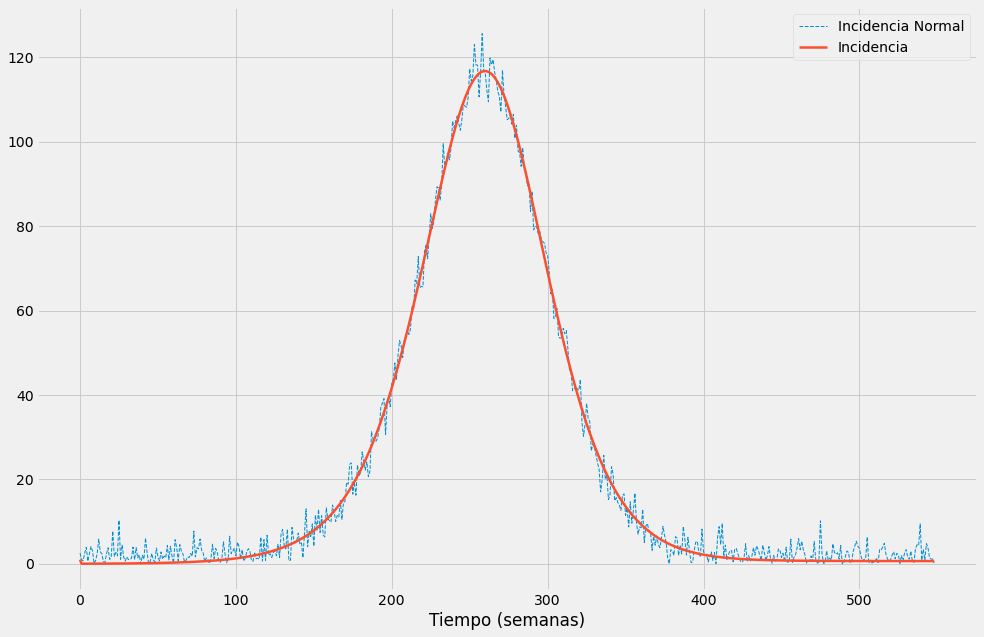

In [192]:
incNor=inc + np.random.normal(size=inc.shape,scale=3)
incNor=abs(incNor)
pl.figure(figsize=(15, 10))
pl.plot(incNor,linestyle="--",markersize=4,label='Incidencia Normal',linewidth=1)
pl.plot(inc,label='Incidencia', linewidth=2.5)
#pl.plot(SOL[:,2])
pl.xlabel('Tiempo (semanas)')
pl.ylabel('')
pl.legend(loc=0)
pl.show()


Incidencia ajustada

In [194]:
SOL1= spi.odeint(ode_SID,INPUT,t_range,args=(0.2508759787090548,
 0.04479509229290371,
 0.0004623952889668548,
 0.41043656687089514,
 0.4999999741201076,
 0.24458441484735077,
 0.49954046748434683))

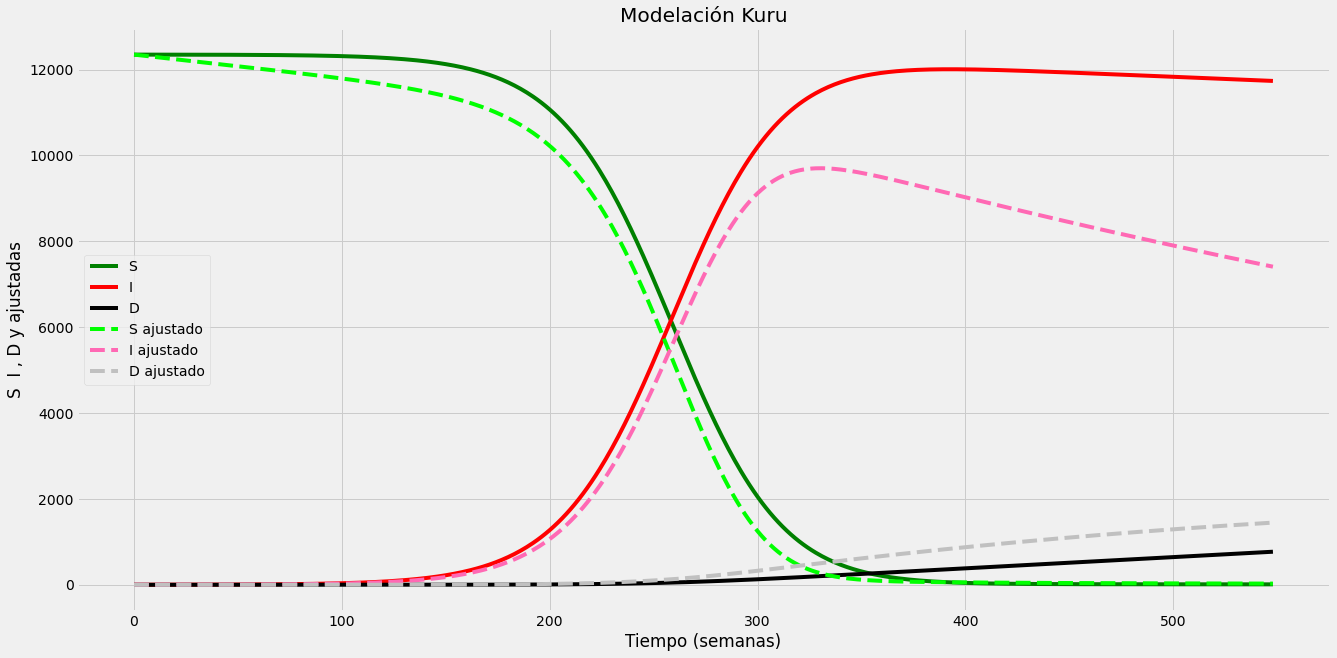

In [195]:
pl.figure(figsize=(20, 10))
pl.plot(SOL[:,0], '-g', label='S ') #S
pl.plot(SOL[:,1], '-r', label='I')# I
pl.plot(SOL[:,2], '-k', label='D ') # D
pl.plot(SOL1[:,0], '--',color='lime', label='S ajustado') #S
pl.plot(SOL1[:,1], '--', color='hotpink',label='I ajustado')# I
pl.plot(SOL1[:,2], '--',color='silver', label='D ajustado') # D
pl.title('Modelación Kuru')
pl.xlabel('Tiempo (semanas)')
pl.ylabel('S  I , D y ajustadas')
pl.legend(loc=0)
pl.show()

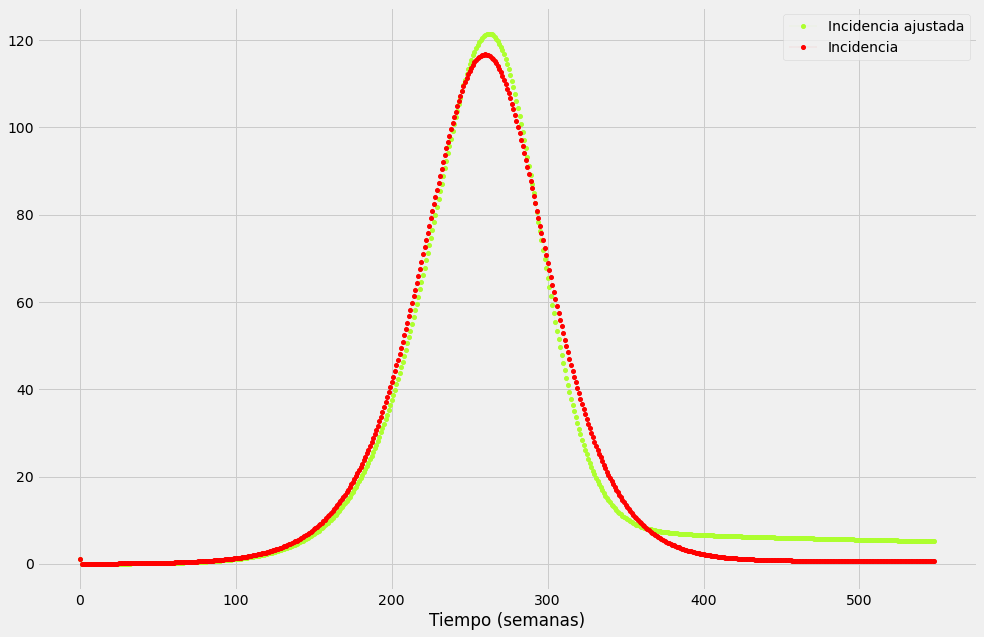

In [196]:
pl.figure(figsize=(15, 10))
incad=np.concatenate((np.array([I0]),np.diff(SOL1[:,3])))
pl.plot(incad,linestyle="--",marker="o",markersize=4,color='greenyellow',linewidth=0.1,label='Incidencia ajustada')
pl.plot(inc,linestyle="--",marker="o",markersize=4,color='red',linewidth=0.1,label='Incidencia')
#pl.plot(SOL[:,2])
pl.xlabel('Tiempo (semanas)')
pl.legend(loc=0)
pl.show()

#Análisis Bayesiano

In [197]:
par1=[2.5,0,1.1]  #hiperpar'ametros para alpha
par2=[5,0,0.3]  #hiperpar'ametros para beta
par3=[1.2,0,0.5]  #hiperpar'ametros para gamma
par4=[1.1,0,0.3] #hiperparámetros para mu1
par5=[1,0,0.2] #hiperparámetros para mu2
par6=[0.5,0,0.1] #hiperparámetros para nu
par7=[1,0,0.25] #hiperparámetros para delta

def logaprioris(theta):
    alpha,beta,gamma,mu1,mu2,nu,delta = theta
    dalpha = scipy.stats.gamma.logpdf(alpha,par1[0],par1[1],par1[2])
    dbeta = scipy.stats.gamma.logpdf(beta,par2[0],par2[1],par2[2])
    dgamma = scipy.stats.gamma.logpdf(gamma,par3[0],par3[1],par3[2])
    dmu1 = scipy.stats.gamma.logpdf(mu1,par4[0],par4[1],par4[2])
    dmu2 = scipy.stats.gamma.logpdf(mu2,par5[0],par5[1],par5[2])
    dnu = scipy.stats.gamma.logpdf(nu,par6[0],par6[1],par6[2])
    ddelta = scipy.stats.gamma.logpdf(delta,par7[0],par7[1],par7[2])
    return(float(dalpha+dbeta+dgamma+dmu1+dmu2+dnu+ddelta))

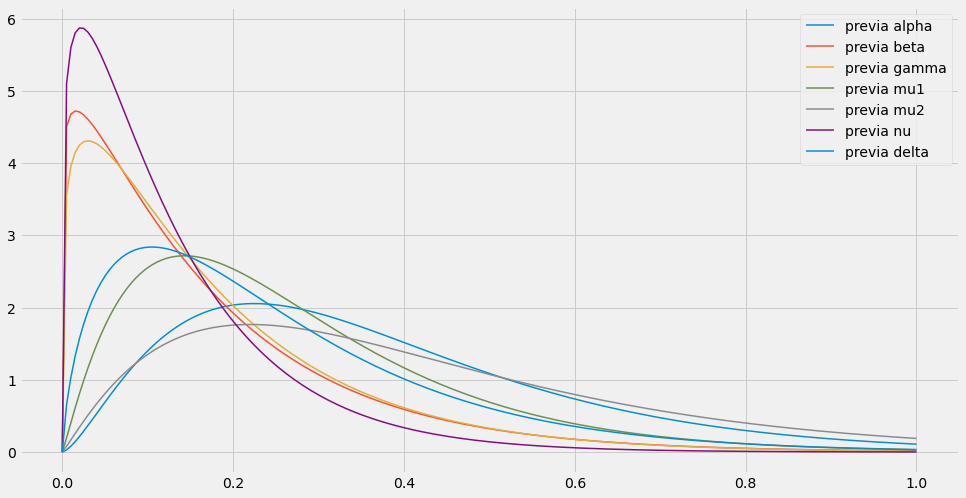

In [198]:
par1=[2.5,0,0.15]  #hiperparámetros para alpha
par2=[1.1,0,0.16]  #hiperparámetros para beta
par3=[1.2,0,0.15]  #hiperparámetros para gamma
par4=[2.1,0,0.13] #hiperparámetros para mu1
par5=[2.1,0,0.2] #hiperparámetros para mu2
par6=[1.2,0,0.11] #hiperparámetros para nu
par7=[1.7,0,0.15] #hiperparámetros para delta
x = np.linspace(0., 1., 200)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
prev3 = scipy.stats.gamma.pdf(x, par3[0],par3[1],par3[2])
prev4 = scipy.stats.gamma.pdf(x, par4[0],par4[1],par4[2])
prev5 = scipy.stats.gamma.pdf(x, par5[0],par5[1],par5[2])
prev6 = scipy.stats.gamma.pdf(x, par6[0],par6[1],par6[2])
prev7 = scipy.stats.gamma.pdf(x, par7[0],par7[1],par7[2])


##Graficamos
pl.figure(figsize=(15, 8))
pl.plot(x, prev1, label='previa alpha',linewidth=1.5)
pl.plot(x, prev2,  label='previa beta',linewidth=1.5)
pl.plot(x, prev3,  label='previa gamma',linewidth=1.5)
pl.plot(x, prev4,  label='previa mu1',linewidth=1.5)
pl.plot(x, prev5,  label='previa mu2',linewidth=1.5)
pl.plot(x, prev6,  label='previa nu',linewidth=1.5)
pl.plot(x, prev7,  label='previa delta',linewidth=1.5)
pl.legend(loc="best")
pl.show()

In [ ]:
def logverosimilitud(theta):
  n_quinc1=7
  alpha,beta,gamma,mu1,mu2,nu,delta=theta.copy()
  t_dias=arange(0,7*n_quinc1,1)
  modelo=integrate.odeint(ode_SID,INPUT,t_dias,args=(alpha,beta,gamma,mu1,mu2,nu,delta,))
  acum_dia=modelo[:,2]
  #Incidencia quincenal
  inc_quinc=incidencia(acum_dia,7)
  #Se están teniendo problemas con los ceros, así que se removerán
  vers=zeros((n_quinc1))
  for i in range(0,n_quinc1):
      if inc_quinc[i]!=0 and data_quinc[i]!=0: 
          vers[i]=-inc_quinc[i]+data_quinc[i]*log(abs(inc_quinc[i]))
      elif inc_quinc[i]!=0 and data_quinc[i]==0:
          vers[i]=-inc_quinc[i]
      #Si inc_sem[i]=0 la verosimilitud de ese dato es cero
  #Sumar porque es el logaritmo de la verosimilitud
  ver=float(sum(vers))
  #print(ver)
  return(ver) 

#### Posterior
def logposterior(theta):
  return(logaprioris(theta)+logverosimilitud(theta))

In [ ]:
#Distribución posterior
def posterior(theta):
    #print("1",logaprioris(theta)+logverosimilitud(theta))
    return((exp(logaprioris(theta)+logverosimilitud(theta))))

In [ ]:
# Genera las propuestas
def rkernelprop(present, sd, size=1):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) / sd, (myclip_b - present) / sd
    proposal = truncnorm.rvs(a,b,loc = present, scale = sd, size=size)
    return(proposal)

# Reporta la densidad de la propuesta    
def dkernelprop(prop,present,sd):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) /sd, (myclip_b - present) / sd
    denproposal = truncnorm.pdf(prop, a, b, loc = present, scale = sd)
    return(denproposal)

In [ ]:
def inicializa():
  flag=False
  while flag==False:
    a = scipy.stats.gamma.rvs(par1[0],par1[1],par1[2])
    b = scipy.stats.gamma.rvs(par2[0],par2[1],par2[2])    
    c = scipy.stats.gamma.rvs(par3[0],par3[1],par3[2])
    d = scipy.stats.gamma.rvs(par4[0],par4[1],par4[2])
    e = scipy.stats.gamma.rvs(par5[0],par5[1],par5[2])
    f = scipy.stats.gamma.rvs(par6[0],par6[1],par6[2])
    g = scipy.stats.gamma.rvs(par7[0],par7[1],par7[2])
    tt = np.array([a, b, c, d, e,f,g])
    print("entra")
    if posterior(tt)>0:
      theta_ini = tt
      flag=True
  return(theta_ini)

In [251]:
par1=[1.71,0,0.151]  #hiperparámetros para alpha
par2=[1.72,0,0.152]  #hiperparámetros para beta
par3=[1.73,0,0.153]  #hiperparámetros para gamma
par4=[1.74,0,0.154] #hiperparámetros para mu1
par5=[1.75,0,0.155] #hiperparámetros para mu2
par6=[1.76,0,0.156] #hiperparámetros para nu
par7=[1.77,0,0.157] #hiperparámetros para delta


#Generando los valores iniciales
tt = inicializa()
tt

entra
entra


array([0.20197325, 1.10448205, 0.27403219, 0.25301309, 0.28989708,
       0.08040565, 0.43250167])

In [252]:
def MH(iters, theta_ini, sd):
    theta_act = theta_ini

    alpha_v = np.zeros(iters)          ## guardar cadenas de alfas
    beta_v = np.zeros(iters)          ##guardar cadenas de betas
    gamma_v = np.zeros(iters)          ##guardar cadenas de gammas
    mu1_v = np.zeros(iters)            ##guardar cadenas de mu1s
    mu2_v = np.zeros(iters)             ##guardar cadenas de mu2s
    nu_v = np.zeros(iters)             ##guardar cadenas de nus
    delta_v = np.zeros(iters)          ##guardar cadenas de deltas
    logposter_v = np.empty(iters)   ##guardar todas las posteriores
    
    ### primer entrada de cada cadena
    logposter_v[0] = logposterior(theta_act)
    theta_prop = [0., 0. , 0.,0., 0. , 0.,0.]
    actualizo = 0

    for i in range(1,iters):
        ### empieza propuesta
        theta_prop[0] = rkernelprop(present = theta_act[0], sd = sd, size=1)[0]
        theta_prop[1] = rkernelprop(present = theta_act[1], sd = sd, size=1)[0]
        theta_prop[2] = rkernelprop(present = theta_act[2], sd = sd, size=1)[0]
        theta_prop[3] = rkernelprop(present = theta_act[3], sd = sd, size=1)[0]
        theta_prop[4] = rkernelprop(present = theta_act[4], sd = sd, size=1)[0]
        theta_prop[5] = rkernelprop(present = theta_act[5], sd = sd, size=1)[0]
        theta_prop[6] = rkernelprop(present = theta_act[6], sd = sd, size=1)[0]
        #print(theta_prop)

        # alfa
        qxy = dkernelprop(theta_act[0], theta_prop[0],sd) * dkernelprop(theta_act[1], theta_prop[1],sd) * dkernelprop(theta_act[2],theta_prop[2],sd) * dkernelprop(theta_act[3],theta_prop[3],sd)* dkernelprop(theta_act[4],theta_prop[4],sd)* dkernelprop(theta_act[5],theta_prop[5],sd)* dkernelprop(theta_act[6],theta_prop[6],sd) #centrada en propuesto
        qyx = dkernelprop(theta_prop[0],theta_act[0],sd) * dkernelprop(theta_prop[1],theta_act[1],sd) * dkernelprop(theta_prop[2],theta_act[2],sd) * dkernelprop(theta_prop[3],theta_act[3],sd)  * dkernelprop(theta_prop[4],theta_act[4],sd) * dkernelprop(theta_prop[5],theta_act[5],sd)* dkernelprop(theta_prop[6],theta_act[6],sd)#centrada en actual
    
        lognum = logposterior(theta_prop)+np.log(qxy)
        logden = logposterior(theta_act)+np.log(qyx)
        razon = np.exp(lognum - logden)
        A = min(1,razon)
        #print(A)
        #print(posterior(theta_prop), posterior(theta_act))

        if np.random.uniform(0,1,1)<A: # actualiza
          alpha_v[i] = theta_prop[0]
          beta_v[i] = theta_prop[1]   
          gamma_v[i] = theta_prop[2]
          mu1_v[i] = theta_prop[3]
          mu2_v[i] = theta_prop[4]
          nu_v[i] = theta_prop[5]
          delta_v[i] = theta_prop[6]
          logposter_v[i] = logposterior(theta_prop)
          theta_act = theta_prop.copy()
          actualizo += 1
        else: # no actualiza
          alpha_v[i] = theta_act[0]
          beta_v[i] = theta_act[1]   
          gamma_v[i] = theta_act[2]
          mu1_v[i] = theta_act[3]
          mu2_v[i] = theta_act[4]
          nu_v[i] = theta_act[5]
          delta_v[i] = theta_act[6]
          logposter_v[i] = logposterior(theta_act)

    rechazo = iters-actualizo        
    theta = np.array([alpha_v, beta_v, gamma_v,mu1_v,mu2_v,nu_v,delta_v])
    return(theta, logposter_v, rechazo, actualizo)

In [259]:
random.seed(2022) 
iters=80000
sims,logpost,rechazo,actualizo=MH(iters=iters,theta_ini=tt,sd=0.004)
%timeit sims
print('rechazó: ',rechazo)
print('actualizó: ',actualizo)

32.6 ns ± 13.4 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)
rechazó:  65004
actualizó:  14996


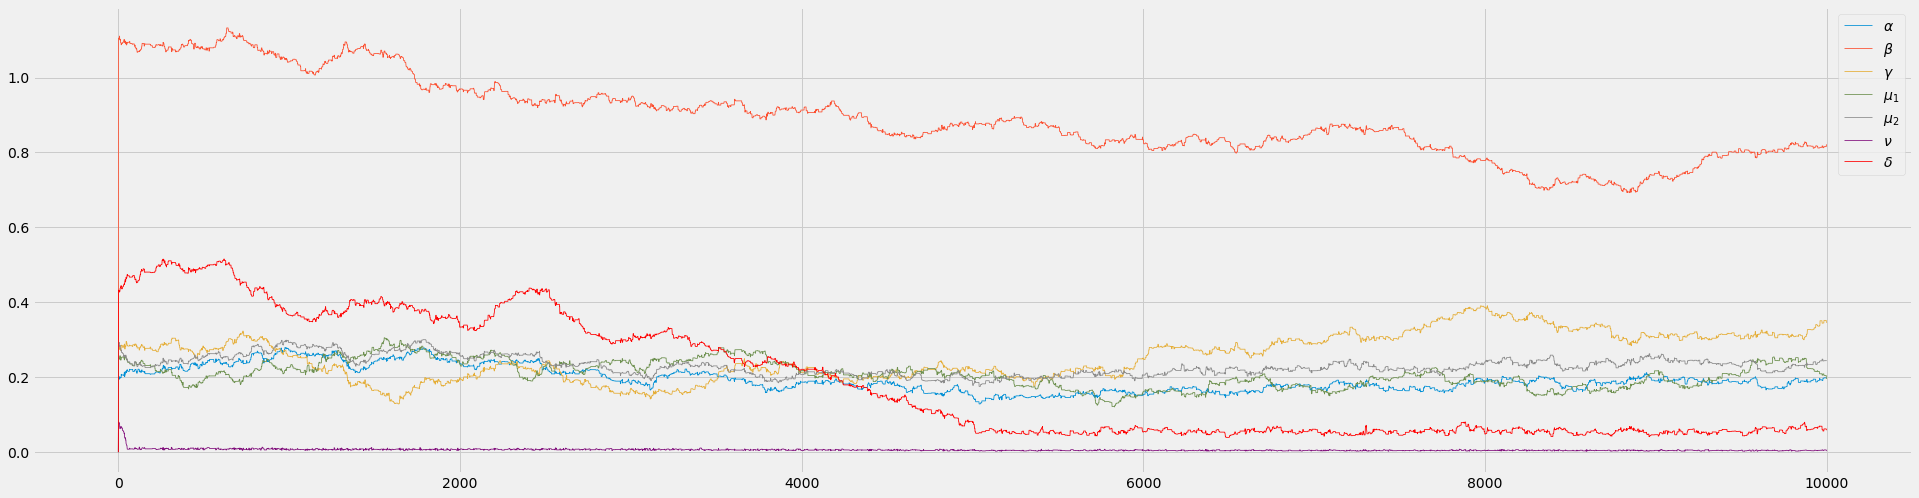

In [256]:
sims.shape
pl.figure(figsize=(30, 8))
pl.plot(sims[0,:], label=r'$\alpha$',linewidth=0.8)
pl.plot(sims[1,:],  label=r'$\beta$',linewidth=0.8)
pl.plot(sims[2,:],  label=r'$\gamma$',linewidth=0.8)
pl.plot(sims[3,:],  label=r'$\mu_1$',linewidth=0.8)
pl.plot(sims[4,:],  label=r'$\mu_2$',linewidth=0.8)
pl.plot(sims[5,:],  label=r'$\nu$',linewidth=0.8)
pl.plot(sims[6,:],  label=r'$\delta$',color='r',linewidth=0.8)
pl.legend(loc="best")
pl.show()

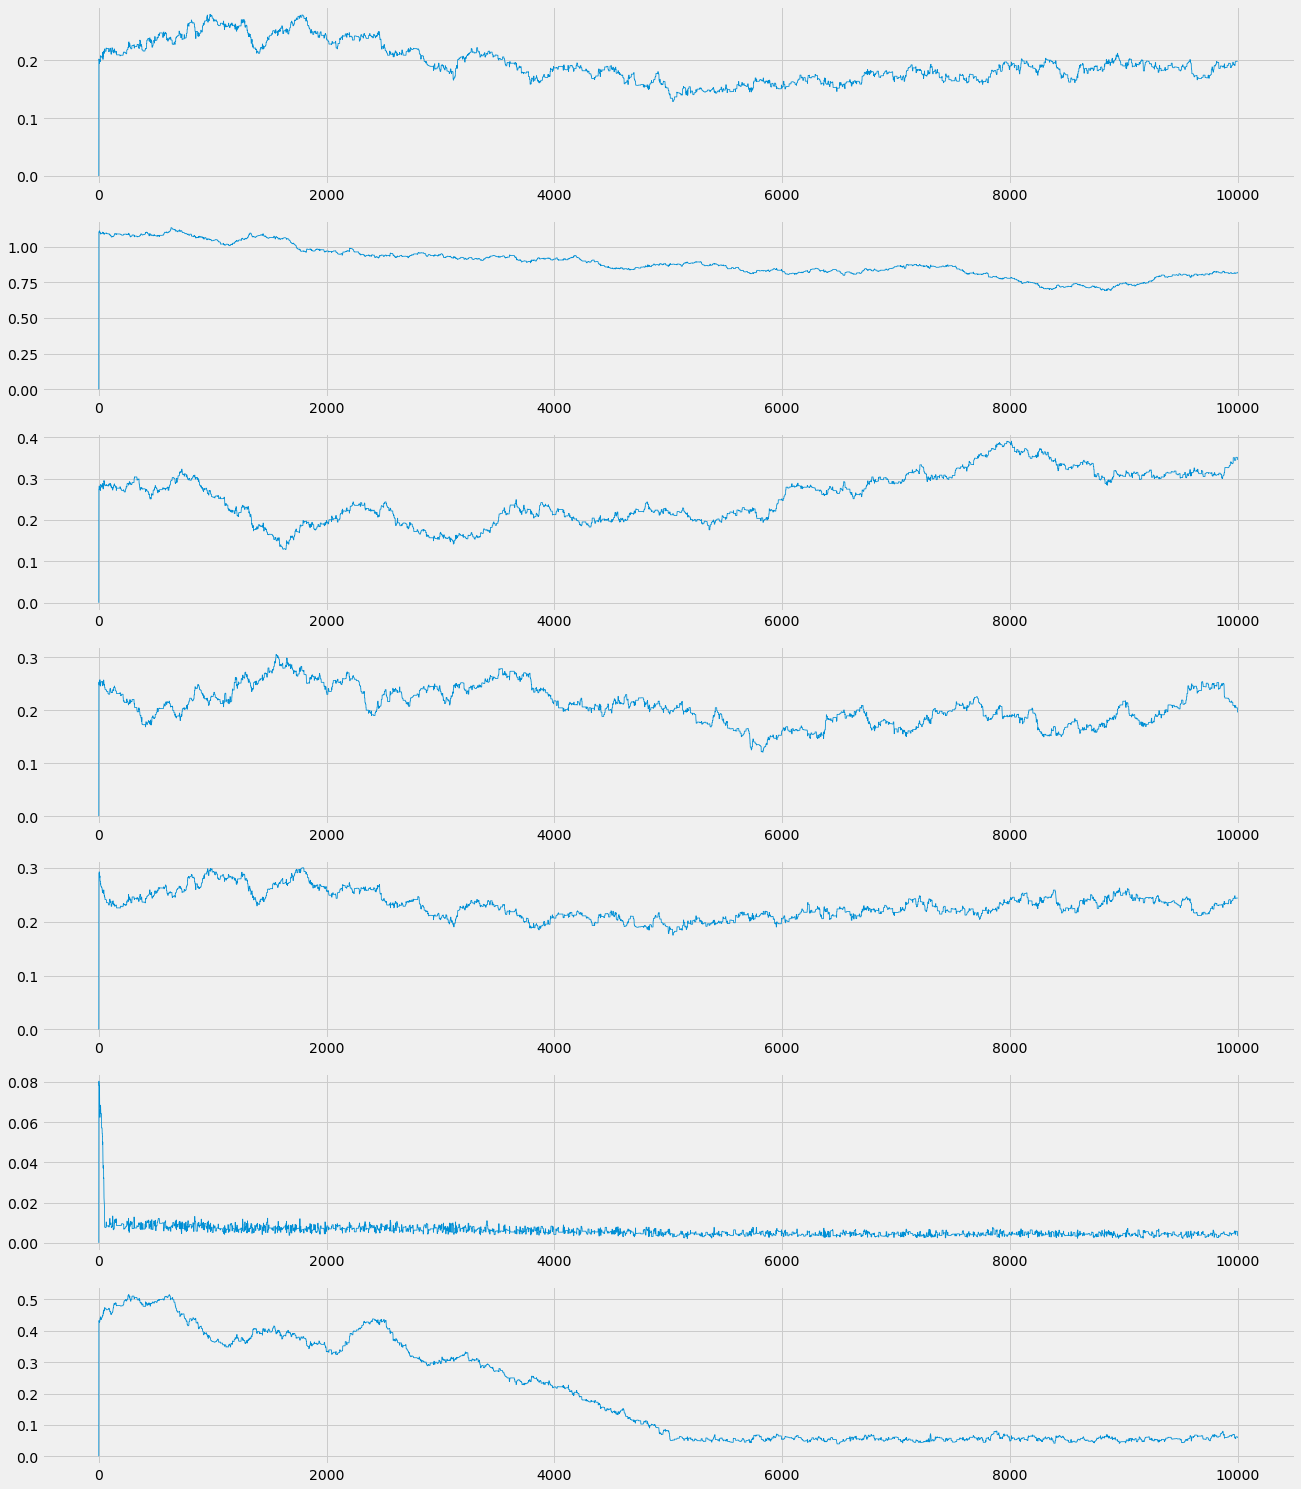

In [257]:
fig,ax=subplots(7,1,figsize=(20,25))
for i in range(7):
  ax[i].plot(sims[i,:],linewidth=0.8)

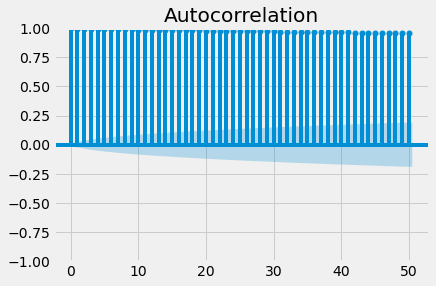

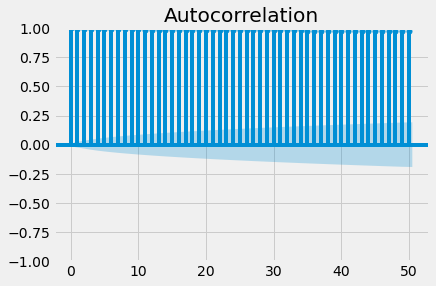

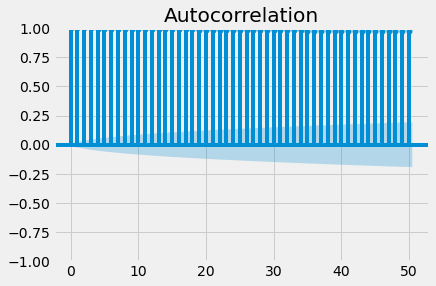

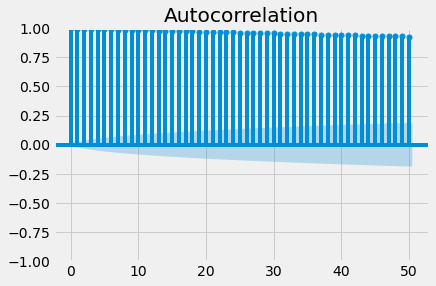

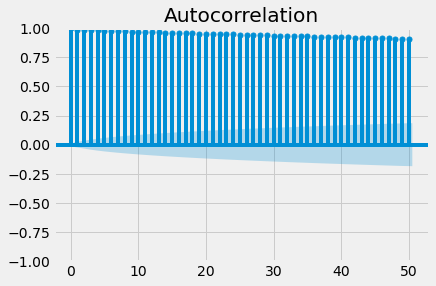

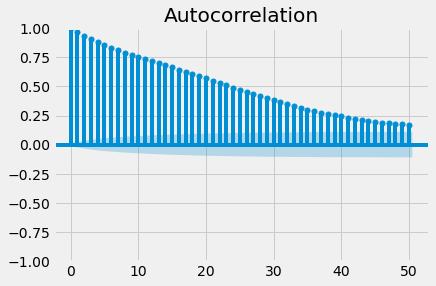

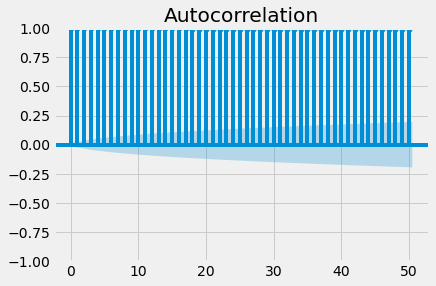

In [258]:
plot_acf(sims[0,:].tolist(),lags=50);
plot_acf(sims[1,:].tolist(),lags=50);
plot_acf(sims[2,:].tolist(),lags=50);
plot_acf(sims[3,:].tolist(),lags=50);
plot_acf(sims[4,:].tolist(),lags=50);
plot_acf(sims[5,:].tolist(),lags=50);
plot_acf(sims[6,:].tolist(),lags=50);

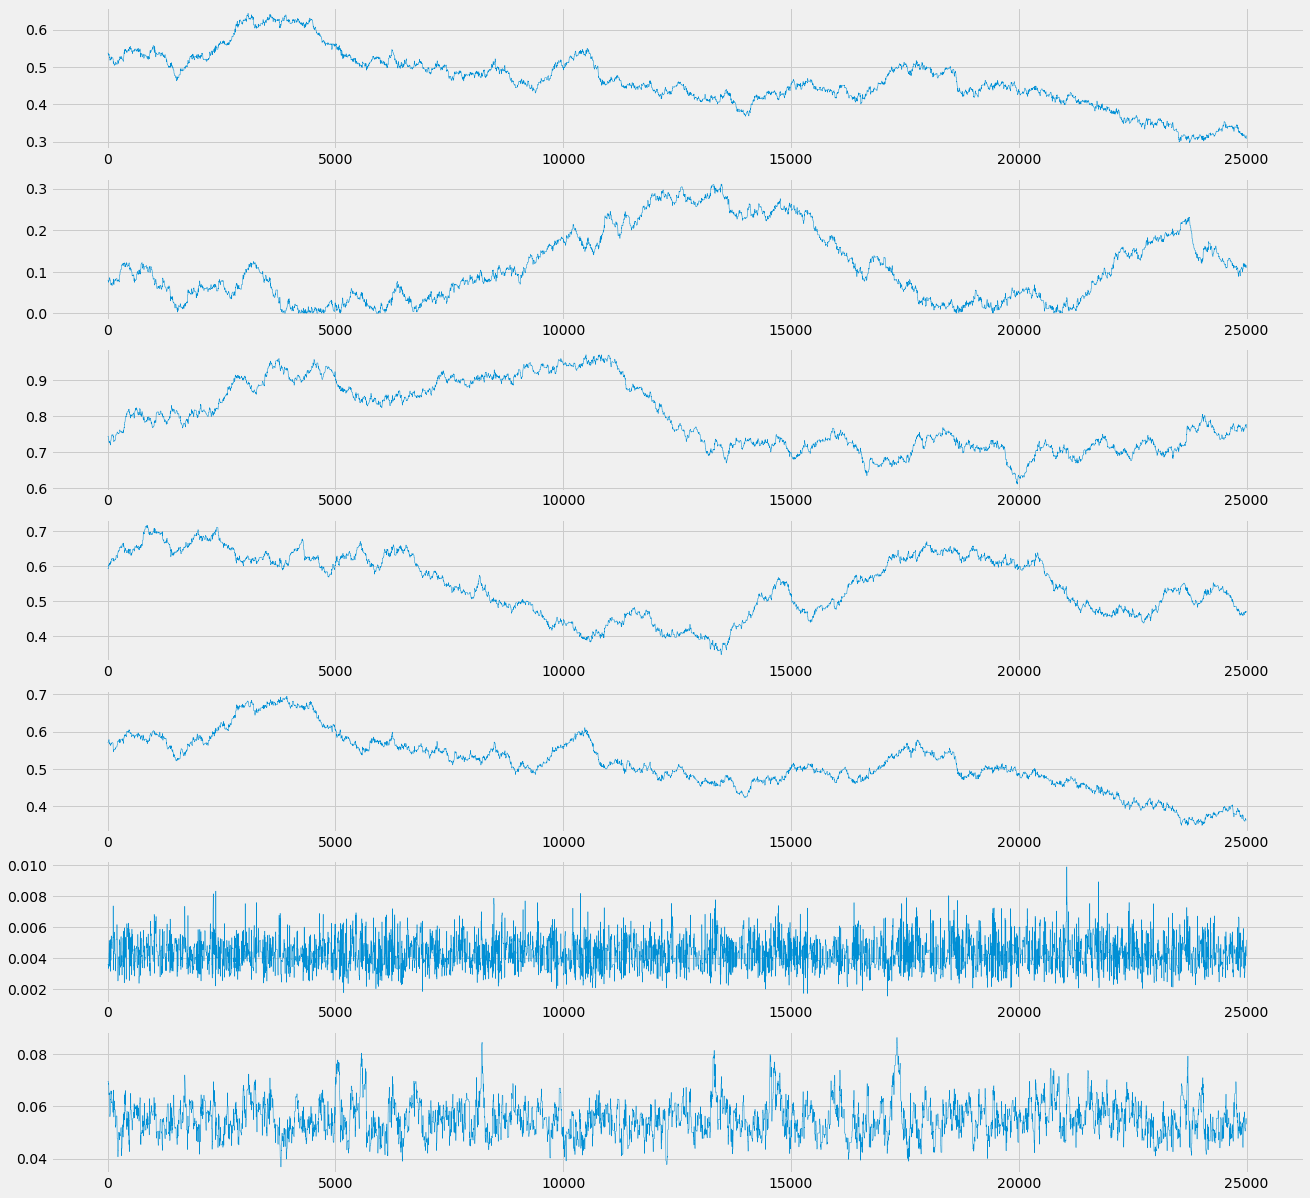

In [229]:
burnin=25000
fig=figure(figsize=(20,20)) 
ax1=subplot(7,1,1) 
ax1.plot(sims[0,burnin:iters],linewidth=0.5)
ax2=subplot(7,1,2)
ax2.plot(sims[1,burnin:iters],linewidth=0.5)
ax3=subplot(7,1,3)
ax3.plot(sims[2,burnin:iters],linewidth=0.5)
ax4=subplot(7,1,4)
ax4.plot(sims[3,burnin:iters],linewidth=0.5)
ax5=subplot(7,1,5)
ax5.plot(sims[4,burnin:iters],linewidth=0.5)
ax6=subplot(7,1,6)
ax6.plot(sims[5,burnin:iters],linewidth=0.5)
ax5=subplot(7,1,7)
ax5.plot(sims[6,burnin:iters],linewidth=0.5)
pl.show()

In [230]:
#Tamaño de muestra efectivo
def ess(data, stepSize=1):
    """ Effective sample size, as computed by BEAST Tracer."""
    samples=len(data)

    assert len(data)>1,"no stats for short sequences"
    maxLag=min(samples//3,1000)

    gammaStat=[0,]*maxLag
    varStat = 0.0;

    if type(data)!=ndarray:
        data=array(data)

    normalizedData=data-data.mean()

    for lag in range( maxLag ):
        v1=normalizedData[:samples - lag]
        v2=normalizedData[lag:]
        v=v1*v2
        gammaStat[lag]=sum(v)/len(v)
        if lag==0:
            varStat=gammaStat[0]
        elif lag%2==0:
            s=gammaStat[lag-1]+gammaStat[lag]
            if s>0:
                varStat+=2.0*s
            else:
                break

    #auto correlation time
    act=stepSize*varStat/gammaStat[0]
    # effective sample size
    ess=(stepSize*samples)/act
    return ess
    
def adelg_cadena(cad_param,saltos):
    n,m=shape(cad_param)
    m_new=int(m/saltos)
    #Matriz con las nuevas cadenas de los parámetros
    cad_new=zeros((n,m_new))
    for i in range(0,n):
        for j in range(0,m_new):
            cad_new[i,j]=cad_param[i,saltos*j]
    return cad_new

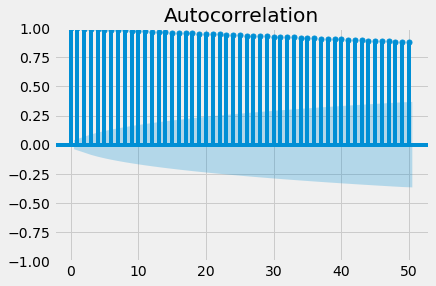

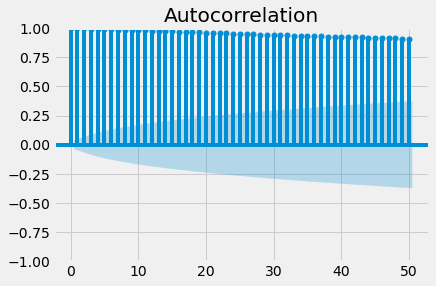

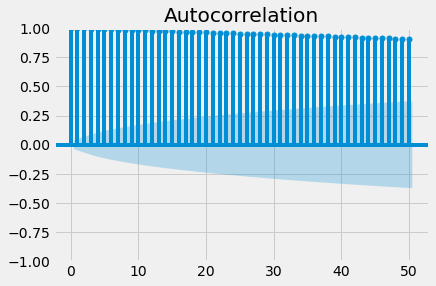

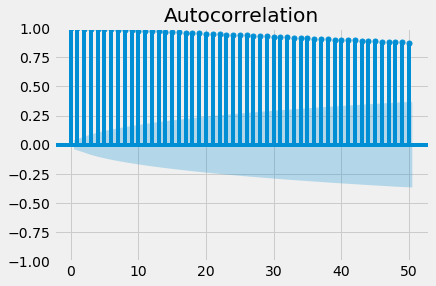

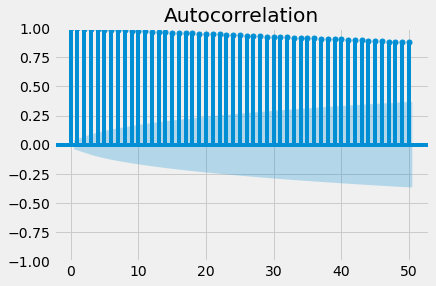

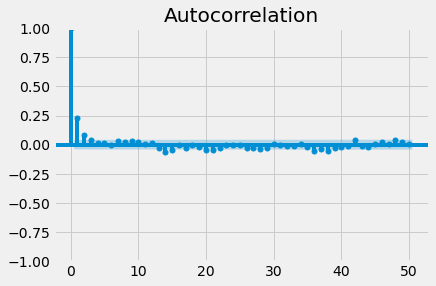

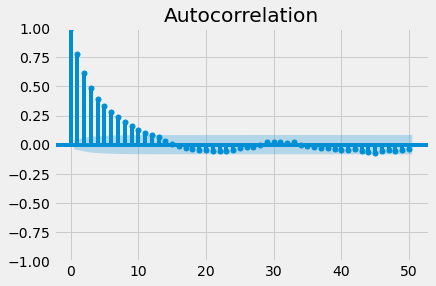

In [231]:
cad_adelg10=adelg_cadena(sims[:,burnin:iters],10)
#Graficar autocorrelaciones las cadenas adelgazadas
plot_acf(cad_adelg10[0,:].tolist(),lags=50);
plot_acf(cad_adelg10[1,:].tolist(),lags=50);
plot_acf(cad_adelg10[2,:].tolist(),lags=50);
plot_acf(cad_adelg10[3,:].tolist(),lags=50);
plot_acf(cad_adelg10[4,:].tolist(),lags=50);
plot_acf(cad_adelg10[5,:].tolist(),lags=50);
plot_acf(cad_adelg10[6,:].tolist(),lags=50);

In [232]:
salpha10=ess(cad_adelg10[0,:])
sbeta10=ess(cad_adelg10[1,:])
sgamma10=ess(cad_adelg10[2,:])
smu110=ess(cad_adelg10[3,:])
smu210=ess(cad_adelg10[4,:])
snu10=ess(cad_adelg10[5,:])
sdelta10=ess(cad_adelg10[6,:])
print("Tamaño de muestra efectivo para cada parámetro: ",[salpha10,sbeta10,sgamma10,smu110,smu210,snu10,sdelta10])

Tamaño de muestra efectivo para cada parámetro:  [4.3042793004818805, 5.612750659496961, 3.3698590201902423, 5.7428416931976995, 4.276091121428034, 1270.46112150989, 285.5852689309969]


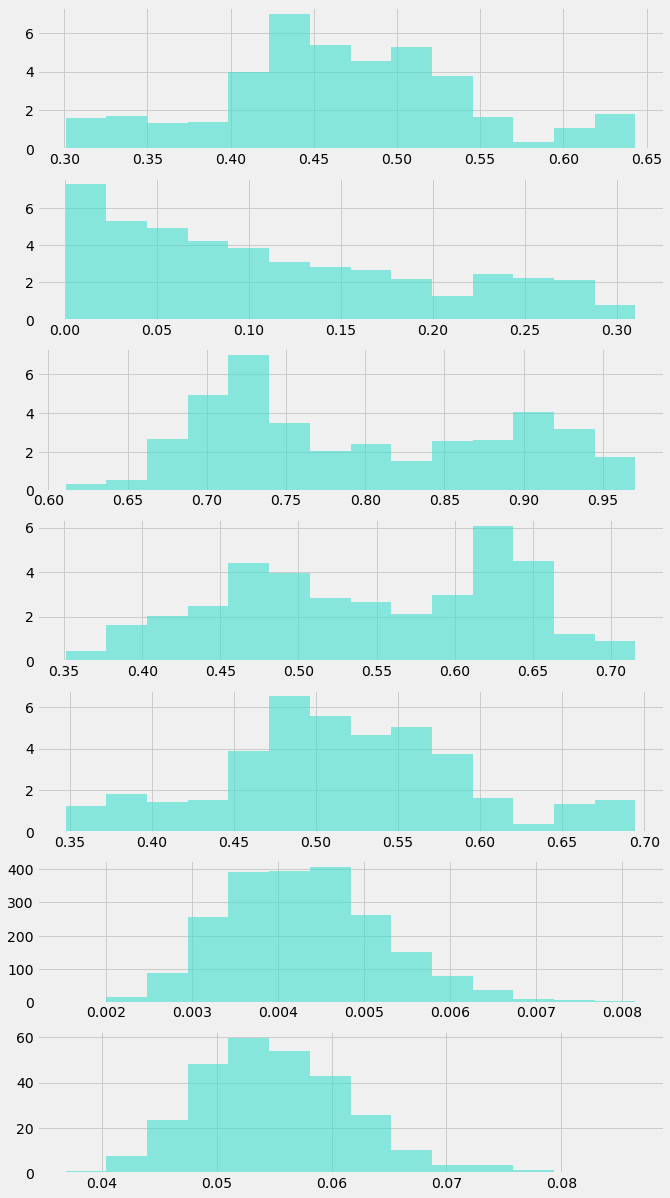

In [233]:
fig=figure(figsize=(10,20)) 

ax1=subplot(7,1,1)
hist(cad_adelg10[0,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);
          
ax2=subplot(7,1,2)
hist(cad_adelg10[1,:],14,density=True,histtype='bar',color ='turquoise',alpha=0.6);

ax3=subplot(7,1,3)
hist(cad_adelg10[2,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

ax4=subplot(7,1,4)
hist(cad_adelg10[3,:],14,density=True,histtype='bar',color ='turquoise',alpha=0.6);

ax5=subplot(7,1,5)
hist(cad_adelg10[4,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

ax6=subplot(7,1,6)
hist(cad_adelg10[5,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

ax7=subplot(7,1,7)
hist(cad_adelg10[6,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

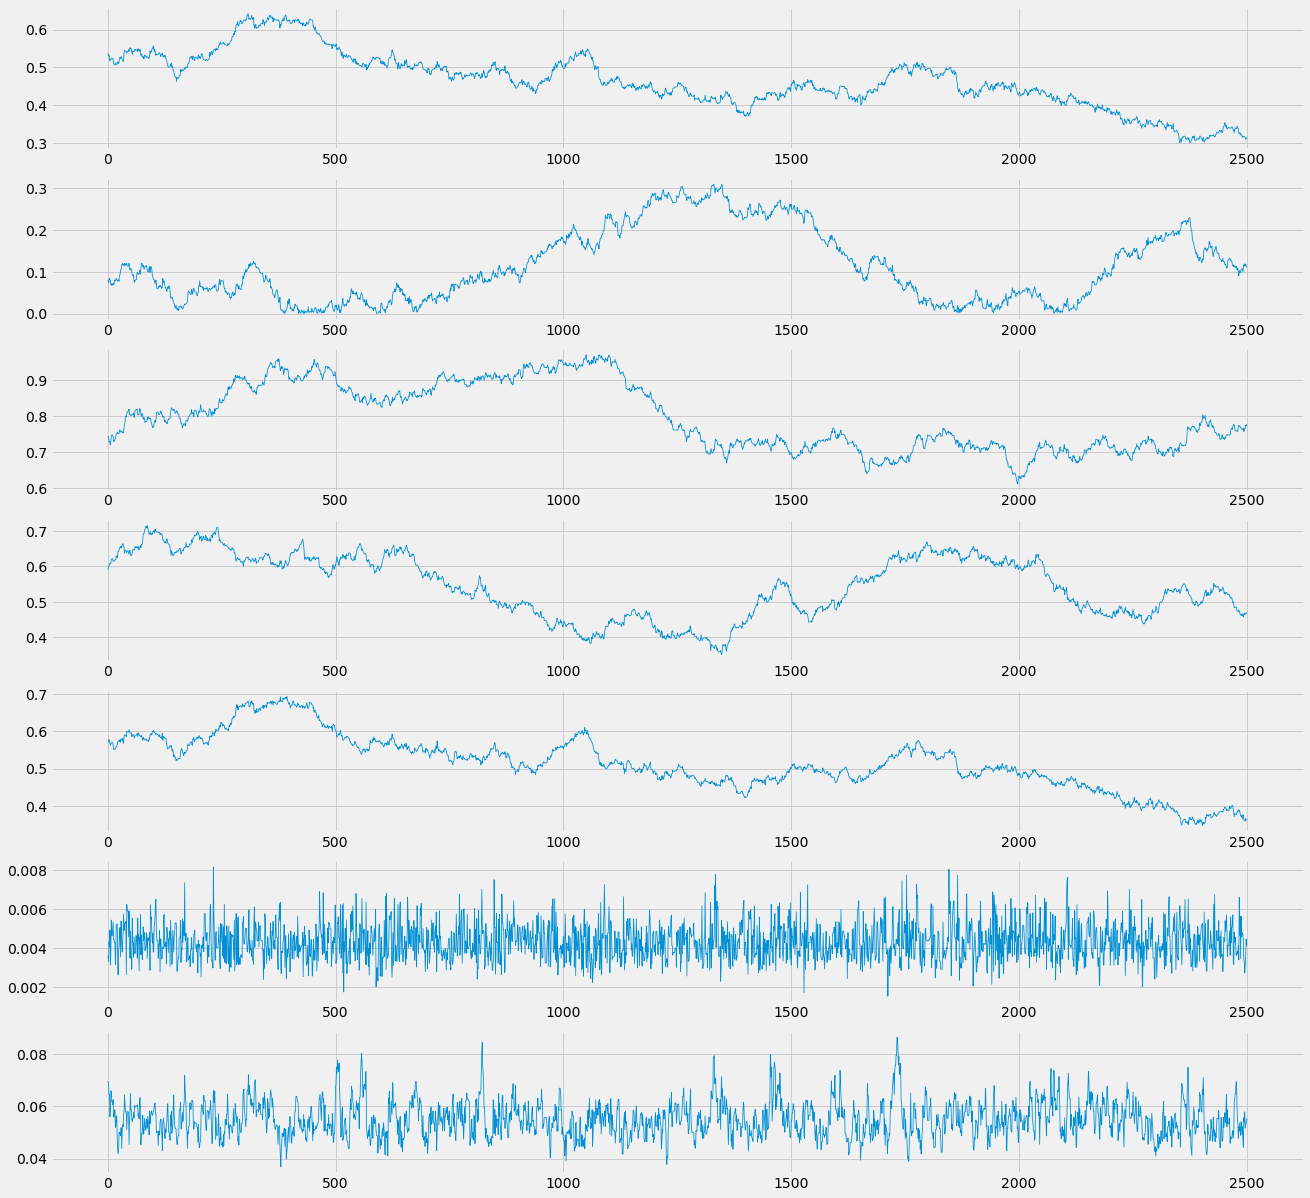

In [235]:
fig=figure(figsize=(20,20)) 
ax1=subplot(7,1,1) 
ax1.plot(cad_adelg10[0,:],linewidth=0.8)
ax2=subplot(7,1,2)
ax2.plot(cad_adelg10[1,:],linewidth=0.8)
ax3=subplot(7,1,3) 
ax3.plot(cad_adelg10[2,:],linewidth=0.8)
ax4=subplot(7,1,4)
ax4.plot(cad_adelg10[3,:],linewidth=0.8)
ax5=subplot(7,1,5)
ax5.plot(cad_adelg10[4,:],linewidth=0.8)
ax6=subplot(7,1,6)
ax6.plot(cad_adelg10[5,:],linewidth=0.8)
ax7=subplot(7,1,7)
ax7.plot(cad_adelg10[6,:],linewidth=0.8)
pl.show()

In [236]:
#Intervalo del 95% de densidad posterior
int_alpha=mquantiles(cad_adelg10[0,:],prob=[0.025,0.975])
int_beta=mquantiles(cad_adelg10[1,:],prob=[0.025,0.975])
int_gamma=mquantiles(cad_adelg10[2,:],prob=[0.025,0.975])
int_mu1=mquantiles(cad_adelg10[3,:],prob=[0.025,0.975])
int_mu2=mquantiles(cad_adelg10[4,:],prob=[0.025,0.975])
int_nu=mquantiles(cad_adelg10[5,:],prob=[0.025,0.975])
int_delta=mquantiles(cad_adelg10[6,:],prob=[0.025,0.975])
                 
print("Intervalo alpha: ",int_alpha)
print("Intervalo beta: ",int_beta)
print("Intervalo gamma: ",int_gamma)
print("Intervalo mu1",int_mu1)
print("Intervalo mu2",int_mu2)
print("Intervalo nu",int_nu)
print("Intervalo delta",int_delta)

Intervalo alpha:  [0.31623231 0.62527972]
Intervalo beta:  [0.00470188 0.28368234]
Intervalo gamma:  [0.66413805 0.95287716]
Intervalo mu1 [0.39208815 0.68802056]
Intervalo mu2 [0.36828315 0.67510319]
Intervalo nu [0.00274105 0.00635005]
Intervalo delta [0.04364451 0.07111174]


In [237]:
#Mediana
median_alpha=mquantiles(cad_adelg10[0,:],prob=[0.5])
median_beta=mquantiles(cad_adelg10[1,:],prob=[0.5])
median_gamma=mquantiles(cad_adelg10[2,:],prob=[0.5])
median_mu1=mquantiles(cad_adelg10[3,:],prob=[0.5])
median_mu2=mquantiles(cad_adelg10[4,:],prob=[0.5])
median_nu=mquantiles(cad_adelg10[5,:],prob=[0.5])
median_delta=mquantiles(cad_adelg10[6,:],prob=[0.5])
print("alpha: ",median_alpha)
print("beta: ",median_beta)
print("Gamma: ",median_gamma)
print("mu1: ",median_mu1)
print("mu2: ",median_mu2)
print("nu: ",median_nu)
print("delta: ",median_delta)

alpha:  [0.45978057]
beta:  [0.09476714]
Gamma:  [0.77001186]
mu1:  [0.54416292]
mu2:  [0.5091716]
nu:  [0.004259]
delta:  [0.05466465]


In [238]:
#Media
media_alpha=mean(cad_adelg10[0,:])
media_beta=mean(cad_adelg10[1,:])
media_gamma=mean(cad_adelg10[2,:])
media_mu1=mean(cad_adelg10[3,:])
media_mu2=mean(cad_adelg10[4,:])
media_nu=mean(cad_adelg10[5,:])
media_delta=mean(cad_adelg10[6,:])
print("alpha: ",media_alpha)
print("beta: ",media_beta)
print("Gamma: ",media_gamma)
print("mu1: ",media_mu1)
print("mu2: ",media_mu2)
print("nu: ",media_nu)
print("delta: ",media_delta)

alpha:  0.4662390161667128
beta:  0.11318641755405279
Gamma:  0.7962429151194735
mu1:  0.545456276799682
mu2:  0.5162329533583447
nu:  0.004316002743553773
delta:  0.05520281685102294


In [239]:
#Moda
moda_alpha=max(cad_adelg10[0,:])
moda_beta=max(cad_adelg10[1,:])
moda_gamma=max(cad_adelg10[2,:])
moda_mu1=max(cad_adelg10[3,:])
moda_mu2=max(cad_adelg10[4,:])
moda_nu=max(cad_adelg10[5,:])
moda_delta=max(cad_adelg10[6,:])

print("alpha: ",moda_alpha)
print("beta: ",moda_beta)
print("Gamma: ",moda_gamma)
print("mu1: ",moda_mu1)
print("mu2: ",moda_mu2)
print("nu: ",moda_nu)
print("delta: ",moda_delta)

alpha:  0.6432199716324513
beta:  0.3099527820257724
Gamma:  0.9705241560747752
mu1:  0.715648153091703
mu2:  0.6944955912599587
nu:  0.008158107387160073
delta:  0.08645106093188455


In [245]:
model_median=integrate.odeint(ode_SID,INPUT,t_range,args=(median_alpha[0],median_beta[0],median_gamma[0],median_mu1[0],median_mu2[0],median_nu[0],median_delta[0],))
Y_acum_median=model_median[:,3]
inc_median=incidencia(Y_acum_median,7)

model_media=integrate.odeint(ode_SID,INPUT,t_range,args=(media_alpha,media_beta,media_gamma,median_mu1,media_mu2,median_nu,median_delta,))
Y_acum_media=model_media[:,3]
inc_media=incidencia(Y_acum_media,7)

model_moda=integrate.odeint(ode_SID,INPUT,t_range,args=(moda_alpha,moda_beta,moda_gamma,moda_mu1,moda_mu2,moda_nu,moda_delta,))
Y_acum_moda=model_moda[:,3]
inc_moda=incidencia(Y_acum_moda,7)

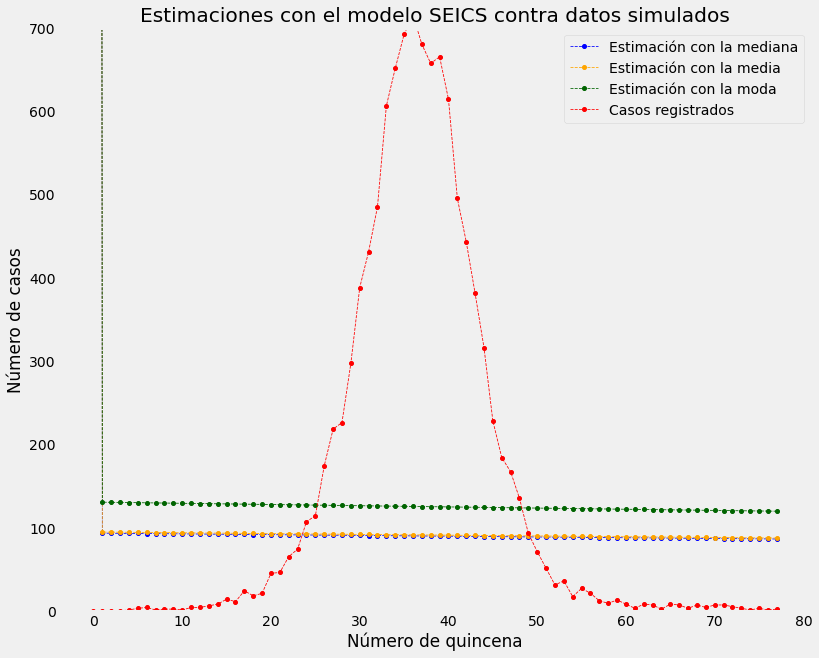

In [250]:
#Graficar el modelo obtenido con los datos estimados contra los datos registrados
pl.figure(figsize=(12,10))
pl.plot(t_quinc,inc_median,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='blue',label="Estimación con la mediana")
pl.plot(t_quinc,inc_media,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='orange',label="Estimación con la media")
pl.plot(t_quinc,inc_moda,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='darkgreen',label="Estimación con la moda")
pl.plot(t_quinc,data_quinc,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='red',label="Casos registrados")
pl.ylabel("Número de casos")
pl.xlabel("Número de quincena")
pl.legend()
pl.title("Estimaciones con el modelo SEICS contra datos simulados")
pl.grid()
#pl.xlim([30,40])
pl.ylim([0,700])
pl.show()